In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import seaborn as sns
import scipy.stats as stats
from statsmodels.stats.multitest import fdrcorrection
import re

In [2]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier

In [3]:
from skbio.stats.composition import clr

In [4]:
import data_loaders 
import target_loaders
import viz_utils
import evaluation
import feature_extraction
import tree_utils

## Setting: loading the data, define the samples, etc.

In [5]:
random_state=0

In [6]:
relative_abundance = data_loaders.load_taxa_in_relative_abundance()
read_count = data_loaders.load_taxa_in_read_count()

age_gender = data_loaders.load_age_and_gender_data()
bmi_data = data_loaders.load_bmi_data()

trig = target_loaders.load_triglyceride()
trig_at_risk = target_loaders.load_triglyceride_at_risk()
log_trig = trig.apply(lambda x: np.log(x))

samples = bmi_data.dropna().index.intersection(trig.dropna().index).intersection(read_count.dropna().index)
compromise_subjects = data_loaders.load_medication_per_subject_filter()
print(f"filtering {compromise_subjects.shape[0]} subject out of {samples.shape[0]} due to medication")
samples = samples.difference(compromise_subjects)
print(f"This analysis will include: {samples.shape[0]} subjects")

relative_abundance = relative_abundance.loc[samples, :]
read_count = read_count.loc[samples, :]
age_gender = age_gender.loc[samples, :]
bmi_data = bmi_data.loc[samples, :]
trig = trig.loc[samples]
trig_at_risk = trig_at_risk.loc[samples]
log_trig = log_trig.loc[samples]


Species that at least 10 % of the samples have relative abundance above the threshold: 0.001
304 out of 52646 species, aka 0.58%


/groups/umcg-lifelines/tmp01/projects/ov22_0666/personal_directories/noamark/Human2Dogs/noa_h2d/Lifeline/data_loaders.py:28: DtypeWarning: Columns (7,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,87,88,89,90,91,92,93,94,97,98,99,100,101,102,103,104,107,108,109,110,111,112,113,114,117,118,119,120,121,122,123,124,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,195,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,259,366,367,368,369,370,371,423,424,425,426,427,428,446,447,449,450,451,452,453,454,455,456,457,458,459,460,461,462,464,465,466,467,470,475) have mixed types. Specify dtype optio

filtering 244 subject out of 1010 due to medication
This analysis will include: 845 subjects


In [7]:
# Add psuedo count to handle the assumption for positive-only
PSUEDO_COUNT = 1
clr_taxa = clr(read_count+PSUEDO_COUNT)
clr_taxa= pd.DataFrame(clr_taxa, index=read_count.index, columns=read_count.columns)

In [8]:
# Define the train, test split once. 
from sklearn.model_selection import train_test_split

X_train_samples, X_test_samples, y_train_samples, y_test_samples = train_test_split(
    pd.DataFrame(index=samples), trig_at_risk, test_size=0.2, random_state=random_state, stratify=trig_at_risk)

X_train_samples, X_test_samples, y_train_samples, y_test_samples = X_train_samples.index, X_test_samples.index, y_train_samples.index, y_test_samples.index

### Data visualizations: 

<Axes: ylabel='Frequency'>

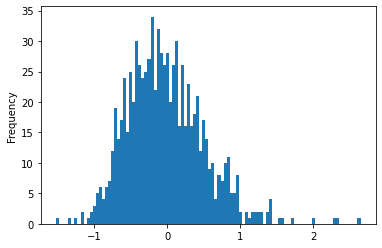

In [9]:
log_trig.plot.hist(bins=100)

Text(0.5, 1.0, 'max')

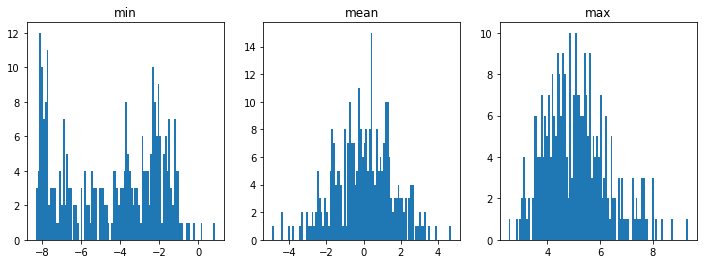

In [10]:
# Vis:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
axes[0].hist(clr_taxa.min(), bins=100)
axes[0].set_title('min')
axes[1].hist(clr_taxa.mean(), bins=100)
axes[1].set_title('mean')
axes[2].hist(clr_taxa.max(), bins=100)
axes[2].set_title('max')

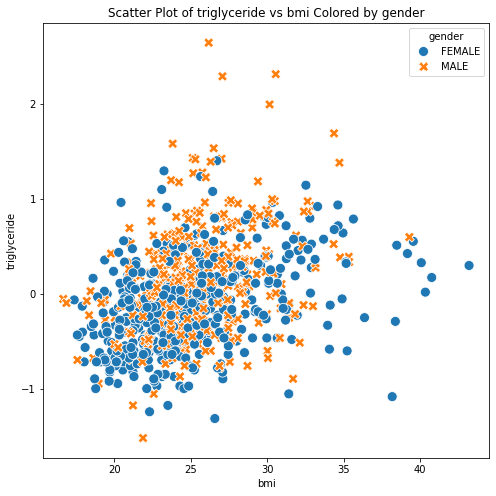

In [11]:
# Let's create a scatter plot showing trig vs. bmi colored by gender:

# sns.set(style='whitegrid')

# Create the scatter plot
plt.figure(figsize=(8, 8))
scatter_plot = sns.scatterplot(data=pd.concat([log_trig.to_frame('log_trig'), bmi_data, age_gender],axis=1), x='bmi', y='log_trig', hue='gender', style='gender', s=100)

# Adding title and labels
scatter_plot.set_title('Scatter Plot of triglyceride vs bmi Colored by gender')
scatter_plot.set_xlabel('bmi')
scatter_plot.set_ylabel('triglyceride')

# Show the plot
plt.legend(title='gender')
plt.show()


## PCoA:

In [12]:
# Let's preform PCA on the CLR data to get PCoA with aitchison distance
from sklearn.decomposition import PCA
clr_taxa_train = clr_taxa.loc[X_train_samples, :]
pca = PCA()
pca_train = pca.fit_transform(clr_taxa_train)
pca_train = pd.DataFrame(pca_train, index=X_train_samples)
pca_train.columns= pca_train.columns.map(lambda x: f'PC{x+1}')

### Pca viz:

In [13]:
# Let's try to understand better the PCA by looking at the explained variance:
print(pca.explained_variance_ratio_[:10])

[0.12421531 0.08273841 0.05484668 0.03862834 0.03224317 0.02844156
 0.02785348 0.02531034 0.02038631 0.017812  ]


In [14]:
pd.Series(pca.explained_variance_ratio_.cumsum())

0      0.124215
1      0.206954
2      0.261800
3      0.300429
4      0.332672
         ...   
299    0.999983
300    0.999990
301    0.999996
302    1.000000
303    1.000000
Length: 304, dtype: float64

In [15]:
pca.explained_variance_ratio_.cumsum()[50]

np.float64(0.7604130988243681)

In [16]:
pca.explained_variance_ratio_[0].round(2)

np.float64(0.12)

<Axes: xlabel='PC1', ylabel='log_trig'>

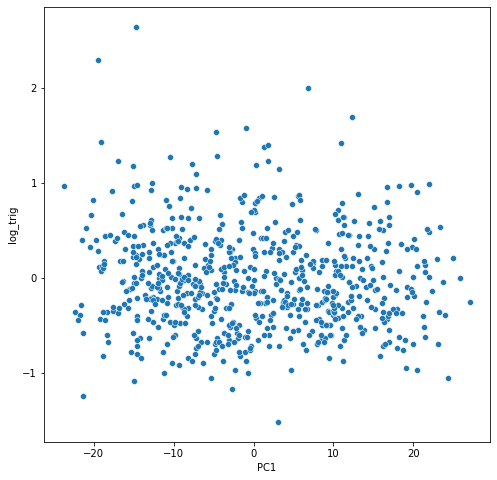

In [17]:
# Plot trig levels vs. top component 
# Scatter plot of trig vs. the first component
plt.figure(figsize=(8, 8))
sns.scatterplot(data=pd.DataFrame({'log_trig': log_trig.loc[pca_train.index], 'PC1': pca_train.iloc[:, 0]}), x='PC1', y='log_trig')

Text(0, 0.5, 'PC2 (explained variance 0.08 %)')

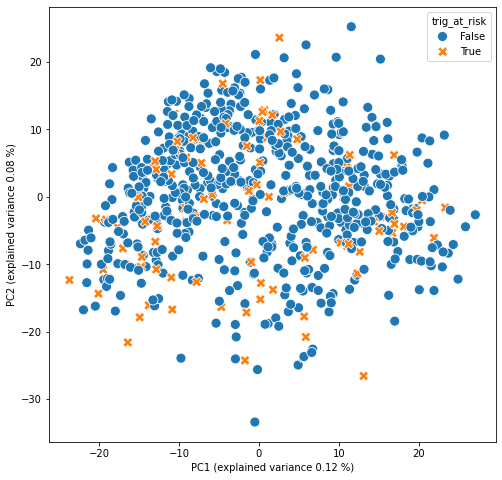

In [18]:
# Scatter plot of the first & second component colored by trig_at_risk yes/no
fig, ax = plt.subplots(figsize=(8, 8))
sns.scatterplot(data=pd.DataFrame({'trig_at_risk': trig_at_risk.loc[pca_train.index], 'PC1': pca_train.iloc[:, 0], 'PC2': pca_train.iloc[:, 1]}),
                x='PC1', y='PC2', hue='trig_at_risk', style='trig_at_risk', s=100)
ax.set_xlabel(f'PC1 (explained variance {pca.explained_variance_ratio_[0].round(2)} %)')
ax.set_ylabel(f'PC2 (explained variance {pca.explained_variance_ratio_[1].round(2)} %)')


<Axes: xlabel='PC2', ylabel='Count'>

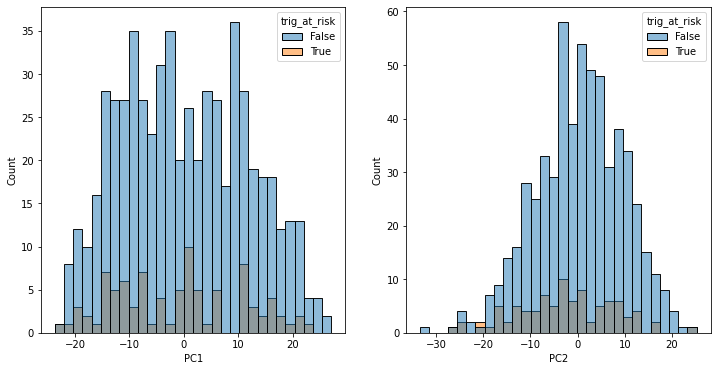

In [19]:
# Plot PCA1 distribution given trig at risk: 
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
sns.histplot(data=pd.DataFrame({'PC1': pca_train.iloc[:, 0], 'trig_at_risk': trig_at_risk}), x='PC1', hue='trig_at_risk', bins=30, ax=axes[0])
sns.histplot(data=pd.DataFrame({'PC2': pca_train.iloc[:, 1], 'trig_at_risk': trig_at_risk}), x='PC2', hue='trig_at_risk', bins=30,  ax=axes[1])

## Baseline:

In [20]:
# Define the target:
y = trig_at_risk

# Define the features:
baseline_ft = pd.concat([age_gender, bmi_data['bmi'].to_frame()], axis=1)
baseline_ft['FEMALE'] = baseline_ft['gender']=='FEMALE'
baseline_ft=baseline_ft.drop(columns='gender')
baseline_ft['FEMALE'] = baseline_ft['FEMALE'].astype(int)

#### Using RF:

In [21]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold

baseline_ft_train = baseline_ft.loc[X_train_samples]
y_train = y.loc[y_train_samples]

random_forest = RandomForestClassifier(random_state=random_state)
param_grid = {'n_estimators': [10, 50, 100],
              'max_depth': [None, 3, 10],
              'min_samples_split': [2, 10, 50],
   'max_features': ['sqrt', 'log2'],
             'class_weight': [None, 'balanced', 'balanced_subsample']}

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=random_state)

search = GridSearchCV(random_forest, param_grid, cv=cv, scoring='roc_auc')
search.fit(baseline_ft_train, y_train)

print(search.best_params_)

base_line_clf = RandomForestClassifier(random_state=random_state, **search.best_params_)
base_line_clf.fit(baseline_ft_train, y_train)

/groups/umcg-lifelines/tmp01/projects/ov22_0666/personal_directories/noamark/Human2Dogs/noa_h2d/lib/python3.10/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


{'class_weight': 'balanced_subsample', 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 50}


RandomForestClassifier(class_weight='balanced_subsample', max_depth=3,
                       n_estimators=50, random_state=0)

In [22]:
# The baseline on the exact same samples:
params = {'class_weight': 'balanced', 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 100}

random_forest = RandomForestClassifier(random_state=random_state)
baseline = RandomForestClassifier(random_state=random_state, **params)
baseline.fit(baseline_ft_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=3, random_state=0)

              precision    recall  f1-score   support

       False       0.92      0.67      0.78       146
        True       0.24      0.65      0.35        23

    accuracy                           0.67       169
   macro avg       0.58      0.66      0.56       169
weighted avg       0.83      0.67      0.72       169



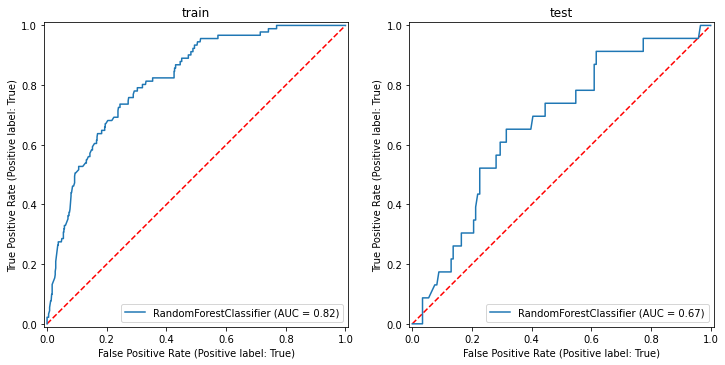

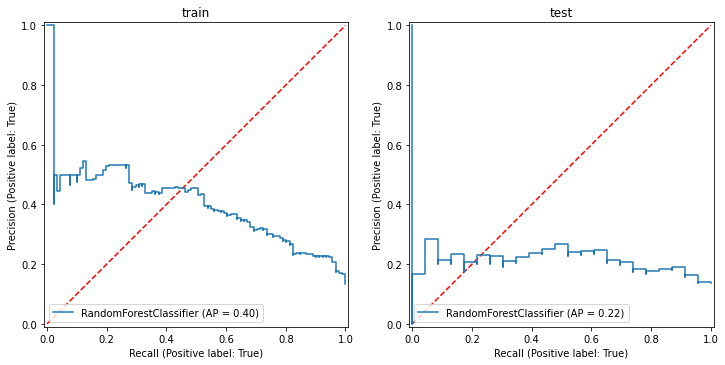

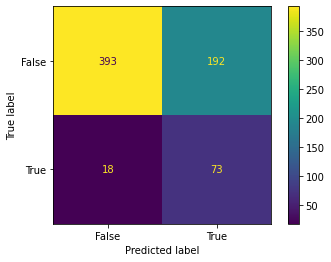

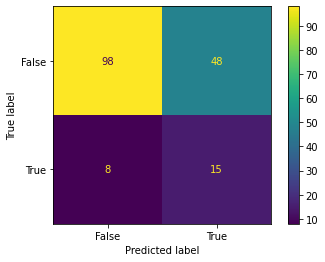

feature importance:


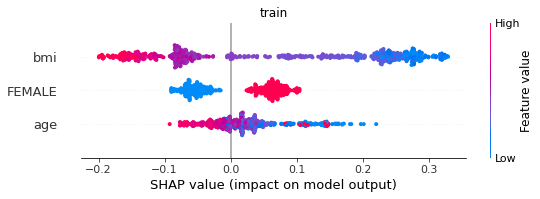

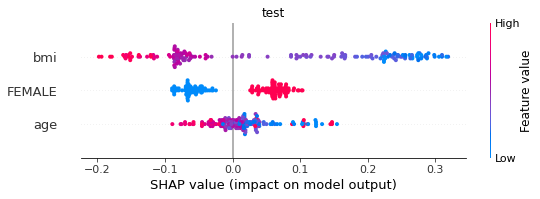

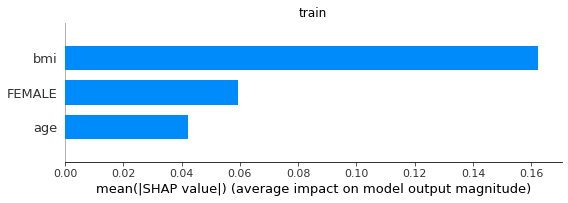

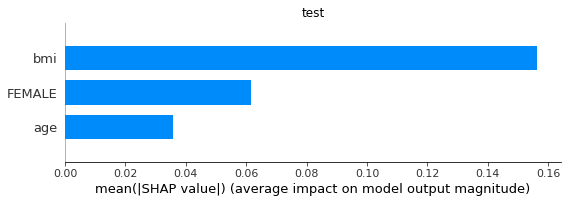

In [23]:
# To evaluate:

baseline_ft_test = baseline_ft.loc[X_test_samples]
y_test = y.loc[y_test_samples]

evaluation.report_clf_preformance(clf=base_line_clf, X_train=baseline_ft_train, y_train=y_train, X_test=baseline_ft_test, y_test=y_test)

#### Using Logistic regression:

In [24]:
from sklearn.linear_model import LogisticRegression

logistic_regression = LogisticRegression(class_weight='balanced')
logistic_regression.fit(baseline_ft_train, y_train)


LogisticRegression(class_weight='balanced')

              precision    recall  f1-score   support

       False       0.92      0.69      0.79       146
        True       0.24      0.61      0.34        23

    accuracy                           0.68       169
   macro avg       0.58      0.65      0.57       169
weighted avg       0.83      0.68      0.73       169



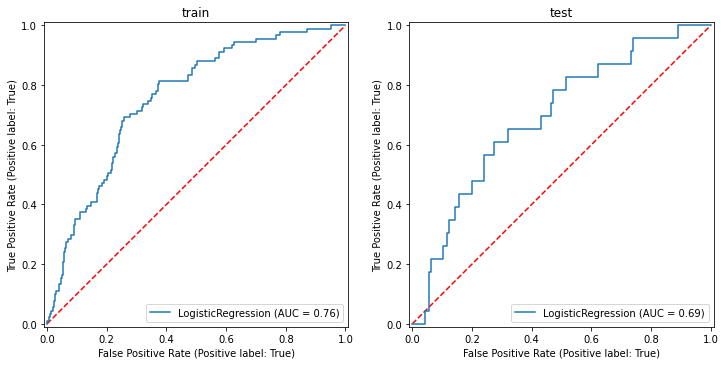

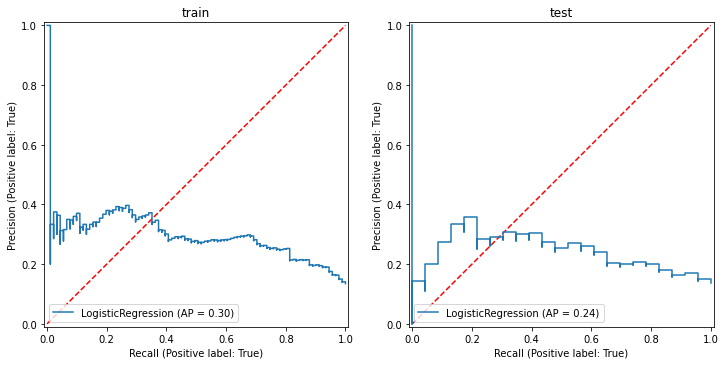

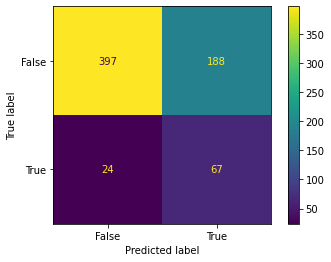

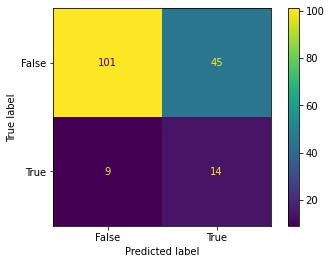

feature importance:


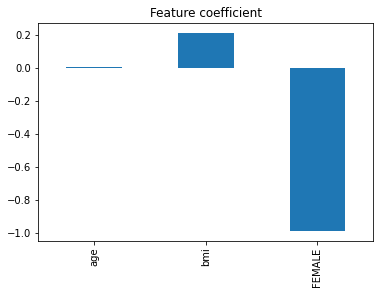

In [25]:
# To evaluate:

baseline_ft_test = baseline_ft.loc[X_test_samples]
y_test = y.loc[y_test_samples]

evaluation.report_clf_preformance(clf=logistic_regression, X_train=baseline_ft_train, y_train=y_train, X_test=baseline_ft_test, y_test=y_test)

## Prediction based on Alpha & Beta diversity: 

Create a model using both Beta-diversity measurements like the first & second PC, and alpha-diversity like shannon-diversity and richness together. (with and without bmi and gender)

In [26]:
# Beta-diversity features include the first few PC:
NUM_PC = 2

shannon_diversity = relative_abundance.apply(feature_extraction.sample_shannon_diversity, axis=1)
richness = relative_abundance.apply(feature_extraction.sample_richness, axis=1)

train_ft = pd.concat([shannon_diversity.loc[X_train_samples].to_frame('shannon_diversity'), richness.loc[X_train_samples].to_frame('richness'), pca_train.iloc[:, :NUM_PC]],axis=1)

In [27]:
train_ft

,shannon_diversity,richness,PC1,PC2
LLDeep_0830,3.696520,301,5.974397,-11.287075
LLDeep_0430,3.312265,304,10.541790,14.094542
LLDeep_0644,3.838134,301,-7.332780,11.700260
LLDeep_0867,3.440486,299,5.906988,-6.761830
LLDeep_1368,3.612888,303,3.746406,9.763064
...,...,...,...,...
LLDeep_1089,3.732417,303,19.911307,-2.644673
LLDeep_0954,3.388089,303,-2.738455,10.469633
LLDeep_0126,2.926095,301,11.814906,-2.269467
LLDeep_0295,3.875421,300,-6.812013,-2.593513


In [28]:
random_forest = RandomForestClassifier(random_state=42)

param_grid = {'n_estimators': [50, 100],
              'max_depth': [None, 3, 10],
              'min_samples_split': [2, 10, 50],
   'max_features': ['sqrt', 'log2'],
             'class_weight': [None, 'balanced']}

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

search = GridSearchCV(random_forest, param_grid, cv=cv, scoring='roc_auc')
search.fit(train_ft, y_train)

print(search.best_params_)

clf = RandomForestClassifier(random_state=random_state, **search.best_params_)
clf.fit(train_ft, y_train)

{'class_weight': 'balanced', 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_split': 50, 'n_estimators': 50}


RandomForestClassifier(class_weight='balanced', max_depth=3,
                       min_samples_split=50, n_estimators=50, random_state=0)

In [29]:
params = {'class_weight': 'balanced', 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 100}


clf = RandomForestClassifier(random_state=random_state, **params)
clf.fit(train_ft, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=3, random_state=0)

In [30]:
clr_taxa_test = clr_taxa.loc[X_test_samples, :]
pca_test = pca.transform(clr_taxa_test)
pca_test = pd.DataFrame(pca_test, index=X_test_samples)
pca_test.columns= pca_test.columns.map(lambda x: f'PC{x+1}')

test_ft = pd.concat([shannon_diversity.loc[X_test_samples].to_frame('shannon_diversity'), richness.loc[X_test_samples].to_frame('richness'), pca_test.iloc[:, :NUM_PC]],axis=1)

              precision    recall  f1-score   support

       False       0.88      0.89      0.89       146
        True       0.27      0.26      0.27        23

    accuracy                           0.80       169
   macro avg       0.58      0.58      0.58       169
weighted avg       0.80      0.80      0.80       169



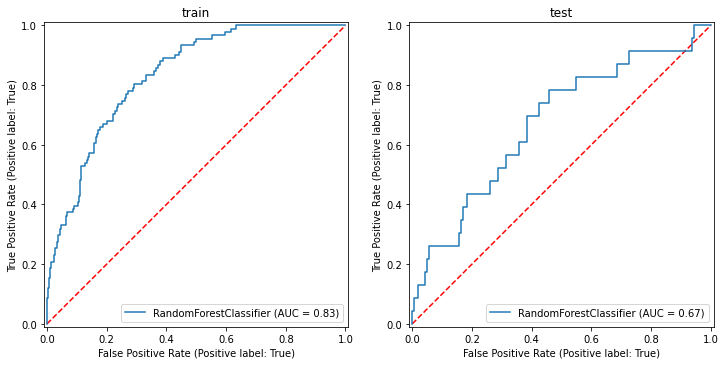

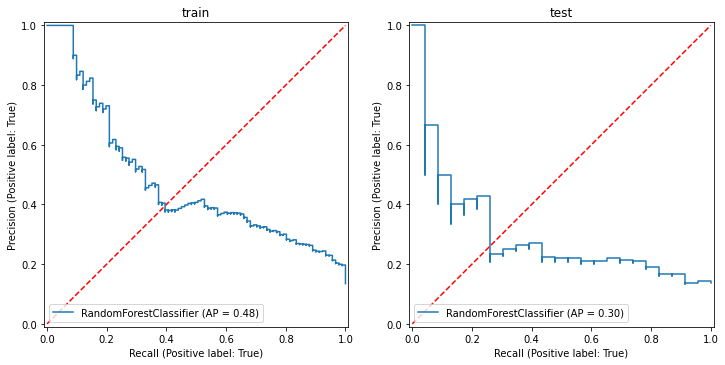

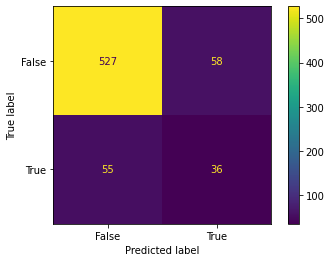

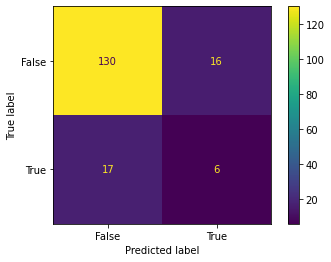

feature importance:


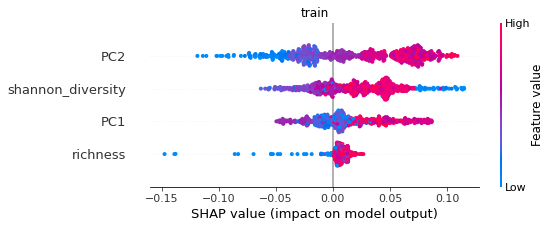

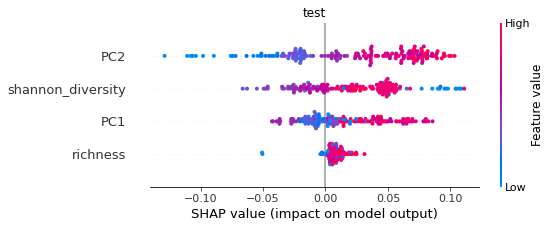

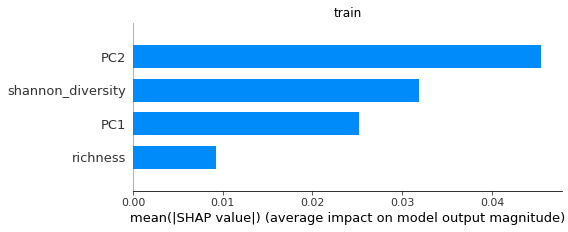

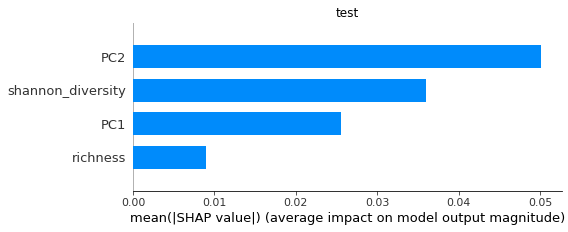

In [31]:
evaluation.report_clf_preformance(clf=clf, X_train=train_ft, y_train=y_train, X_test=test_ft, y_test=y_test)

### Microbiome features & BMI & Gender:

In [32]:
# Define the target:
y = trig_at_risk

y_train = y.loc[y_train_samples]
y_test = y.loc[y_test_samples]


In [33]:
# Define the features:
baseline_ft = pd.concat([age_gender, bmi_data['bmi'].to_frame()], axis=1)
baseline_ft['FEMALE'] = baseline_ft['gender']=='FEMALE'
baseline_ft=baseline_ft.drop(columns='gender')
baseline_ft['FEMALE'] = baseline_ft['FEMALE'].astype(int)

In [34]:
# TODO: try with (and without) the BMI and Gender features. 
NUM_PC = 2

shannon_diversity = relative_abundance.apply(feature_extraction.sample_shannon_diversity, axis=1)
richness = relative_abundance.apply(feature_extraction.sample_richness, axis=1)

train_ft = pd.concat([baseline_ft.loc[X_train_samples], shannon_diversity.loc[X_train_samples].to_frame('shannon_diversity'), richness.loc[X_train_samples].to_frame('richness'), pca_train.iloc[:, :NUM_PC]],axis=1)

In [35]:
train_ft.shape

(676, 7)

In [36]:
# params = {'class_weight': 'balanced', 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 100}
# params = {'class_weight': 'balanced', 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_split': 50, 'n_estimators': 100}
params = {'class_weight': 'balanced', 'max_depth': 3, 'max_features': 1, 'min_samples_split': 50, 'n_estimators': 100}


clf = RandomForestClassifier(random_state=random_state, **params)
clf.fit(train_ft, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=3, max_features=1,
                       min_samples_split=50, random_state=0)

In [37]:
clr_taxa_test = clr_taxa.loc[X_test_samples, :]
pca_test = pca.transform(clr_taxa_test)
pca_test = pd.DataFrame(pca_test, index=X_test_samples)
pca_test.columns= pca_test.columns.map(lambda x: f'PC{x+1}')

test_ft = pd.concat([baseline_ft.loc[X_test_samples], shannon_diversity.loc[X_test_samples].to_frame('shannon_diversity'), richness.loc[X_test_samples].to_frame('richness'), pca_test.iloc[:, :NUM_PC]],axis=1)

              precision    recall  f1-score   support

       False       0.93      0.75      0.83       146
        True       0.29      0.65      0.40        23

    accuracy                           0.73       169
   macro avg       0.61      0.70      0.61       169
weighted avg       0.84      0.73      0.77       169



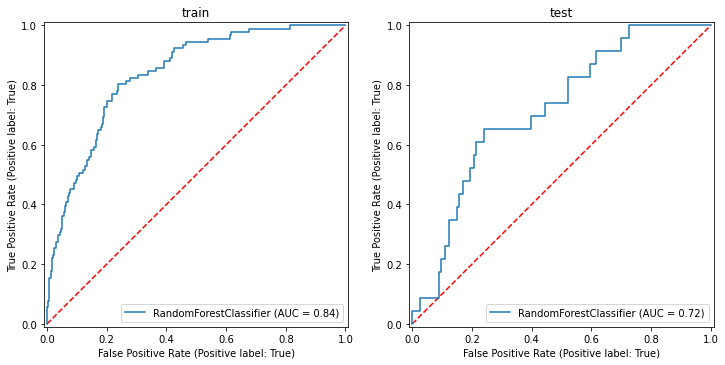

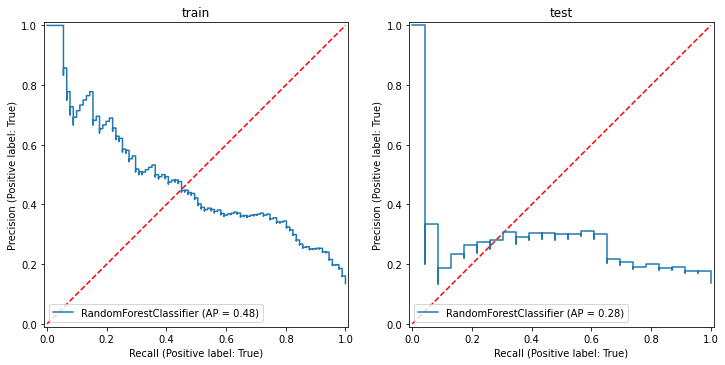

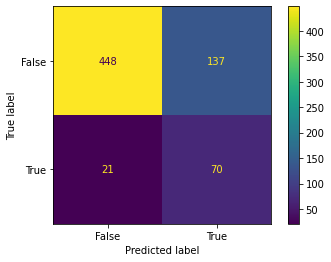

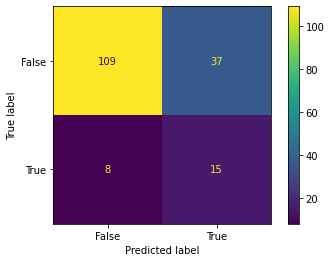

feature importance:


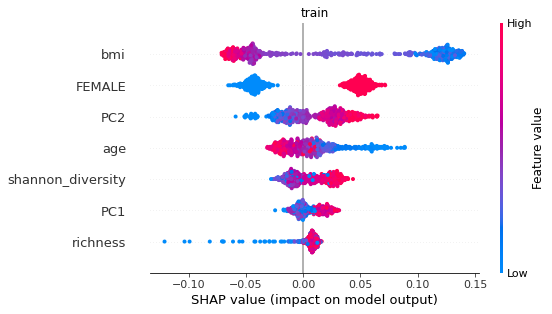

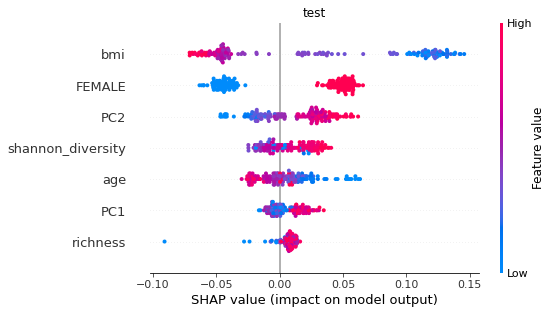

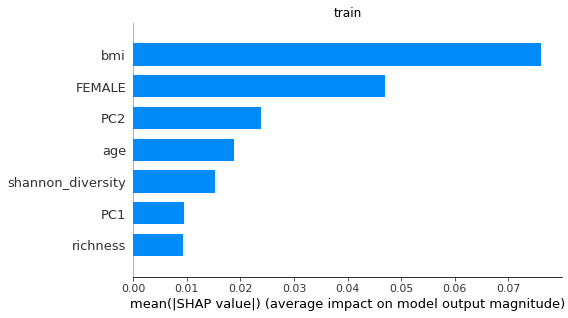

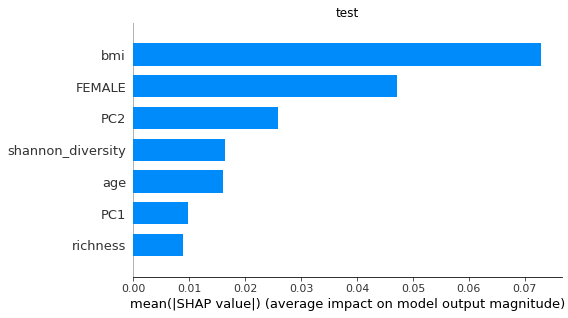

In [38]:
evaluation.report_clf_preformance(clf=clf, X_train=train_ft, y_train=y_train, X_test=test_ft, y_test=y_test)

### TOP PCs

In [39]:
# TODO: train with all the PCs, then select the 10 PCs with the largest SHAP values: 

train_ft = pd.concat([baseline_ft.loc[X_train_samples], shannon_diversity.loc[X_train_samples].to_frame('shannon_diversity'), richness.loc[X_train_samples].to_frame('richness'), pca_train],axis=1)

params = {'class_weight': 'balanced', 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_split': 50, 'n_estimators': 100}
clf = RandomForestClassifier(random_state=random_state, **params)
clf.fit(train_ft, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=3,
                       min_samples_split=50, random_state=0)

In [40]:
test_ft = pd.concat([baseline_ft.loc[X_test_samples], shannon_diversity.loc[X_test_samples].to_frame('shannon_diversity'), richness.loc[X_test_samples].to_frame('richness'), pca_test],axis=1)

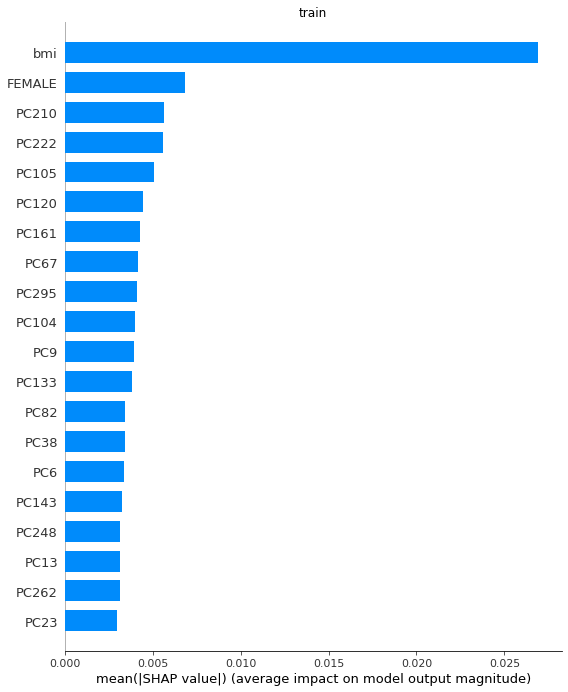

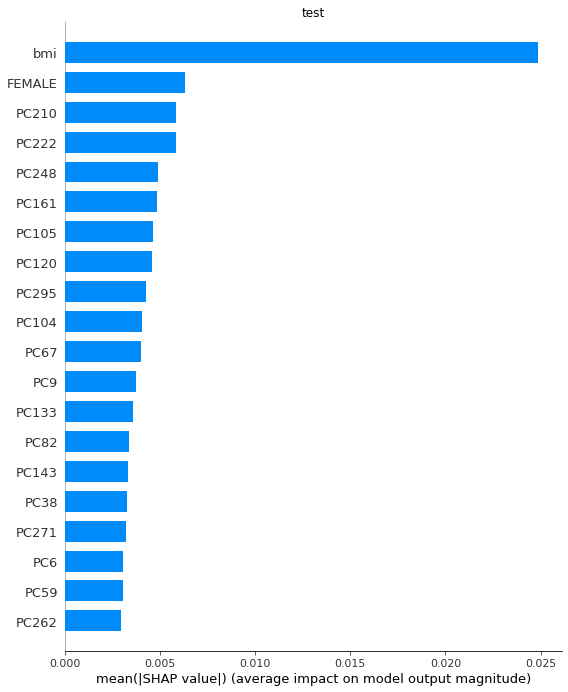

In [41]:
from shap import Explainer, summary_plot
explainer = Explainer(clf)
shap_values_train = explainer.shap_values(train_ft)
shap_values_test = explainer.shap_values(test_ft)
summary_plot(shap_values_train[:,:,0], train_ft, show=False, plot_type="bar")
plt.title('train')
plt.show()
summary_plot(shap_values_test[:,:,0], test_ft, show=False, plot_type="bar")
plt.title('test')
plt.show()

In [42]:
shap_values_test

array([[[-3.90026518e-04,  3.90026518e-04],
        [-1.57793139e-02,  1.57793139e-02],
        [-4.27284470e-03,  4.27284470e-03],
        ...,
        [ 2.61454683e-04, -2.61454683e-04],
        [ 0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00]],

       [[-3.90026518e-04,  3.90026518e-04],
        [-1.66482037e-02,  1.66482037e-02],
        [ 8.28024444e-04, -8.28024444e-04],
        ...,
        [ 8.52087157e-04, -8.52087157e-04],
        [ 0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00]],

       [[-3.90026518e-04,  3.90026518e-04],
        [-2.14569178e-02,  2.14569178e-02],
        [-5.12196281e-03,  5.12196281e-03],
        ...,
        [-3.24733269e-04,  3.24733269e-04],
        [ 0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00]],

       ...,

       [[-1.40316126e-04,  1.40316126e-04],
        [ 3.89547911e-02, -3.89547911e-02],
        [ 2.65089973e-03, -2.65089973e-03],
        ...,
     

In [43]:
shap_values_test = pd.DataFrame(shap_values_test[:,:,0], index=test_ft.index, columns=test_ft.columns)

In [44]:
top_pcs = shap_values_test.sum().sort_values(ascending=False).drop(['bmi','age','FEMALE','shannon_diversity','richness'])

In [45]:
NUM_PC = 10
top_pcs.iloc[:NUM_PC].index

Index(['PC248', 'PC222', 'PC120', 'PC161', 'PC230', 'PC6', 'PC104', 'PC67',
       'PC210', 'PC105'],
      dtype='object')

In [46]:
pca_train.loc[:, top_pcs.iloc[:NUM_PC].index]

,PC248,PC222,PC120,PC161,PC230,PC6,PC104,PC67,PC210,PC105
LLDeep_0830,0.075575,-1.157101,-0.653321,-0.331188,0.356033,1.713514,0.362324,-0.224092,0.723489,-0.968407
LLDeep_0430,-0.030779,0.710560,1.933410,1.308226,0.794858,2.179389,0.110183,-2.594328,-0.316070,-0.805999
LLDeep_0644,0.235576,0.675355,-1.476968,0.068362,0.039903,0.983706,0.358558,-1.171248,-0.294083,0.004621
LLDeep_0867,0.399781,-0.260309,-1.371109,-0.397304,-0.028249,5.369285,0.612177,0.665805,0.500640,-0.928208
LLDeep_1368,-0.461803,-0.499266,0.670164,-0.284640,-0.084709,2.231334,-2.191223,0.610746,-0.583247,0.509563
...,...,...,...,...,...,...,...,...,...,...
LLDeep_1089,-0.289351,-0.099489,-0.570023,-1.270569,-0.213850,-4.066648,0.778227,0.119980,-0.357788,-0.941463
LLDeep_0954,-0.563626,-0.630386,1.909036,-0.076644,0.236258,1.244973,0.849739,-4.377819,-1.395238,-0.906239
LLDeep_0126,-0.261055,0.101096,-1.173121,0.111375,0.273699,2.601909,-0.536073,0.521327,0.337926,0.081386
LLDeep_0295,0.127280,0.313612,0.795391,-0.120081,0.205056,5.725273,-1.761383,2.282210,-0.531998,-0.933112


In [47]:
train_ft = pd.concat([baseline_ft.loc[X_train_samples], shannon_diversity.loc[X_train_samples].to_frame('shannon_diversity'), richness.loc[X_train_samples].to_frame('richness'), pca_train.loc[:, top_pcs.iloc[:NUM_PC].index]],axis=1)

params = {'class_weight': 'balanced', 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_split': 50, 'n_estimators': 100}
clf = RandomForestClassifier(random_state=random_state, **params)
clf.fit(train_ft, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=3,
                       min_samples_split=50, random_state=0)

In [48]:
test_ft = pd.concat([baseline_ft.loc[X_test_samples], shannon_diversity.loc[X_test_samples].to_frame('shannon_diversity'), richness.loc[X_test_samples].to_frame('richness'), pca_test.loc[:, top_pcs.iloc[:NUM_PC].index]],axis=1)

              precision    recall  f1-score   support

       False       0.88      0.82      0.85       146
        True       0.19      0.26      0.22        23

    accuracy                           0.75       169
   macro avg       0.53      0.54      0.53       169
weighted avg       0.78      0.75      0.76       169



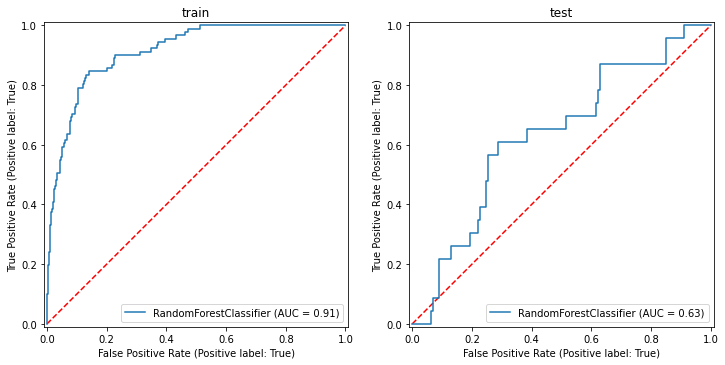

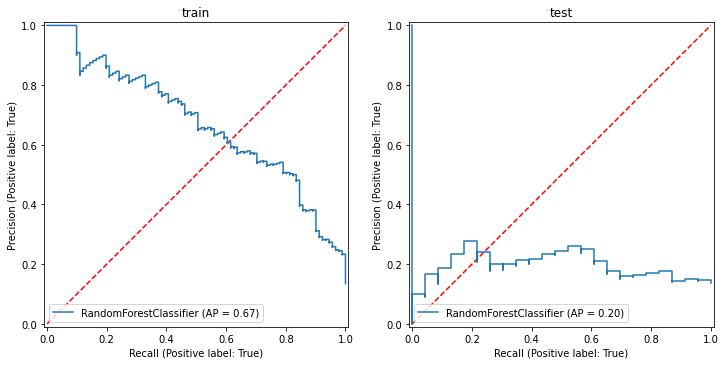

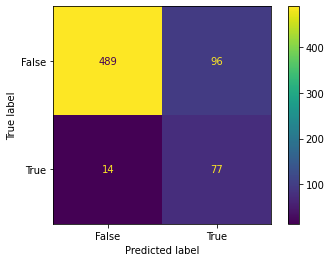

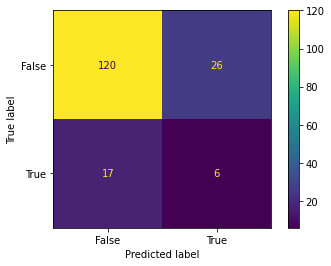

feature importance:


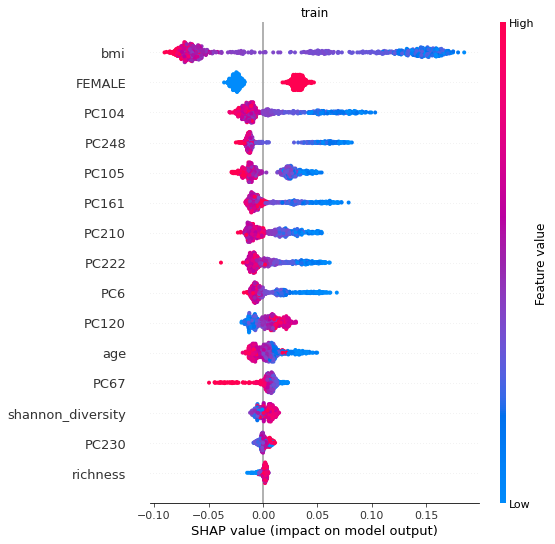

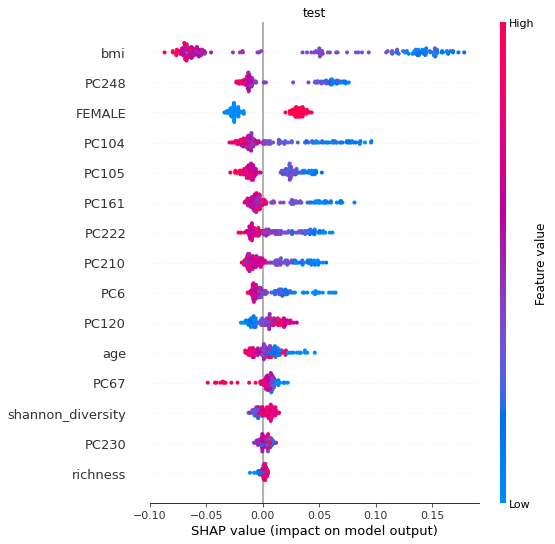

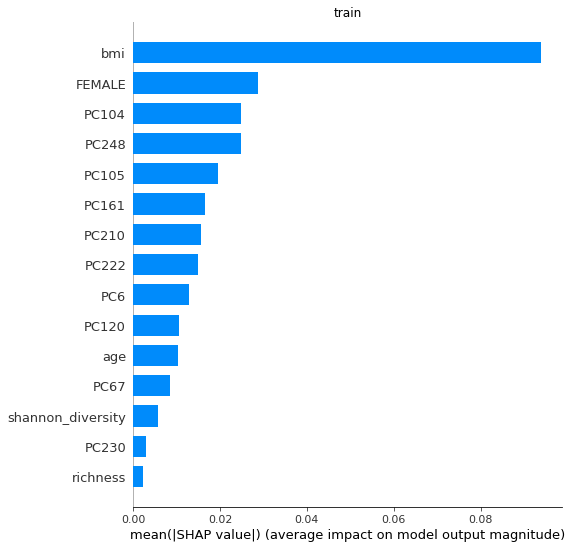

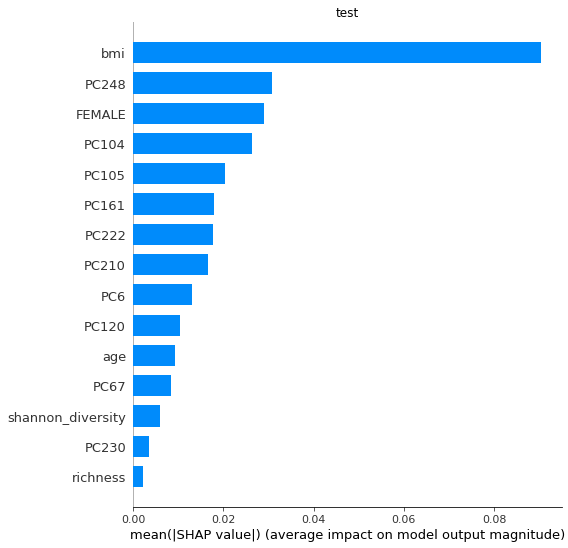

In [49]:
evaluation.report_clf_preformance(clf=clf, X_train=train_ft, y_train=y_train, X_test=test_ft, y_test=y_test)

### Prediction using all the CLR data:

## Taxonomic information:

To get the full taxonomic hierarchy, we will use GTDB data, from the same version used when assigning the taxonoy with Brakan. 
Downloaded from the following link:
https://data.gtdb.ecogenomic.org/releases/release207/207.0/bac120_metadata_r207.tar.gz

Or for the tree format download the link:
https://data.gtdb.ecogenomic.org/releases/release207/207.0/bac120_r207.tree.tar.gz

(as follows: 
! wget https://data.gtdb.ecogenomic.org/releases/release207/207.0/bac120_r207.tree.tar.gz
! tar -xvzf bac120_r207.tree.tar.gz

To create heirarcal clustering using the taxonomic tree we need:
1. GTDB taxonomic tree (like a Newick tree) that describes the relationships between taxa (kingdom, phylum, class, order, family, genus, species).
2. Use this taxonomic tree to define the linkage matrix (distance matrix between any of the leaves)
3. Build build a custom hierarchical dendrogram in Scipy (a Tree /  a branching diagram that represents the relationships of similarits)
4. Integrate the dendrogram into the seaborn heatmap

/groups/umcg-lifelines/tmp01/projects/ov22_0666/personal_directories/noamark/Human2Dogs/noa_h2d/Lifeline/tree_utils.py:23: DtypeWarning: Columns (61,65,74,82,83,85) have mixed types. Specify dtype option on import or set low_memory=False.
  taxaonomic_info = pd.read_csv(taxaonomic_info_path, sep='\t')


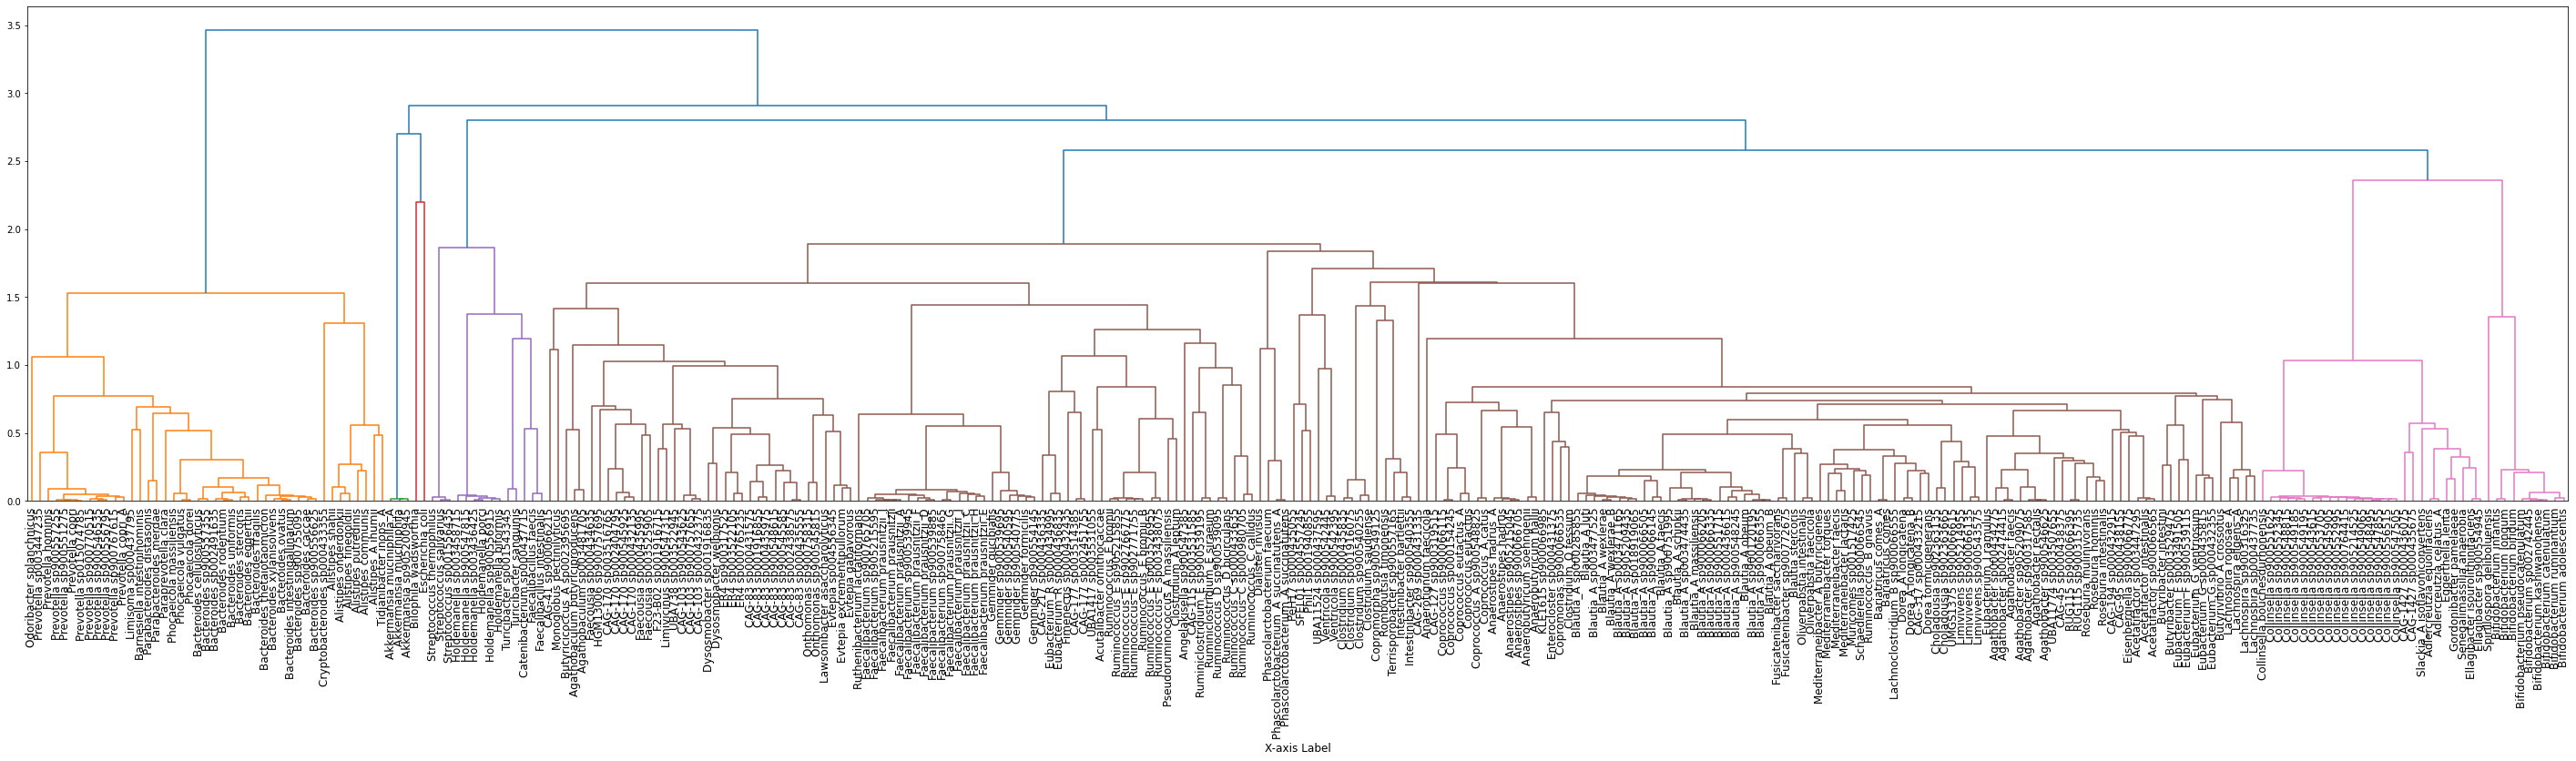

In [9]:

plt.figure(figsize=(50, 10))

dendro, Z = tree_utils.get_dendogram_representation_of_phylogentic_clustering(clr_taxa)


plt.rcParams['xtick.labelsize'] = 12

plt.xlabel('X-axis Label', fontsize=12)

plt.tick_params(axis='x', labelsize=12)

plt.show()

Coloring the lables of the leaf in the dendogram based on the correlation coeficient values:

/groups/umcg-lifelines/tmp01/projects/ov22_0666/personal_directories/noamark/Human2Dogs/noa_h2d/Lifeline/tree_utils.py:23: DtypeWarning: Columns (61,65,74,82,83,85) have mixed types. Specify dtype option on import or set low_memory=False.
  taxaonomic_info = pd.read_csv(taxaonomic_info_path, sep='\t')
/local/3806916/ipykernel_26864/1233026521.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis')


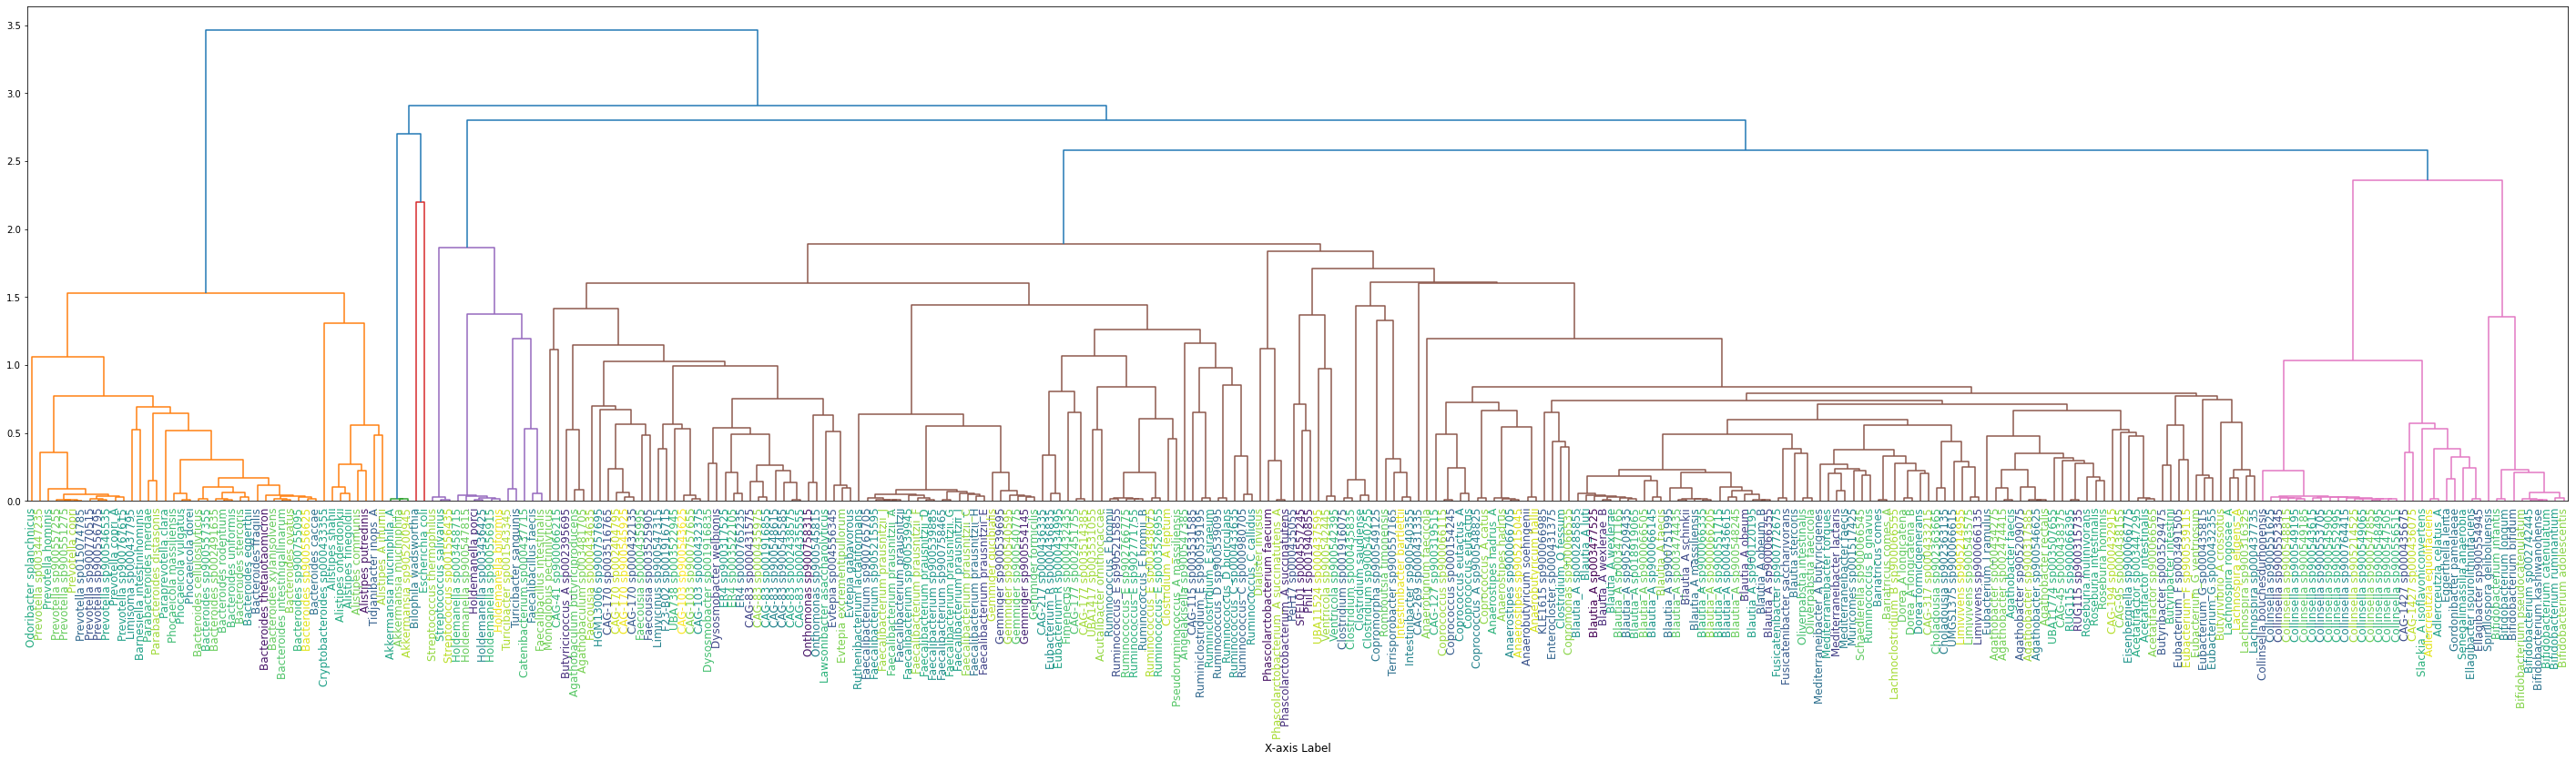

In [52]:
# Now, Instead of coloring the dendogram based on the taxonomic distance we will color each leaf and parent based on the 
# Correlation coefficient of the CLR/ RA with the log trig levels:

# First version we will look on the leaves values labels only.
# Second version we will look on the leaves values, and the parent we will take the mean of the leafs. 

# First try: 

import matplotlib.cm as cm
import matplotlib.colors as mcolors

plt.figure(figsize=(50, 10))

dendro, Z = tree_utils.get_dendogram_representation_of_phylogentic_clustering(clr_taxa)


norm = mcolors.Normalize(vmin=log_trig_clr_corr_coef.min(), vmax=log_trig_clr_corr_coef.max())
cmap = cm.get_cmap('viridis')
node_colors = cmap(norm(log_trig_clr_corr_coef.values))

# Color the leaf nodes based on normalized values
for i, d in zip(dendro['leaves'], node_colors):
    plt.gca().get_xticklabels()[i].set_color(d)  # Set leaf node colors based on values

plt.rcParams['xtick.labelsize'] = 12

plt.xlabel('X-axis Label', fontsize=12)

plt.tick_params(axis='x', labelsize=12)

sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Needed to prevent error with ScalarMappable
plt.colorbar(sm, ax=ax, label='Color Scale')

plt.show()


# Second try: 
# Try to look into 'leaves_color_list' value in the dendogram and ajust it

Define the taxonomic tree:
1. Load GTDB version 207 taxonomic tree in Newick format (Download Newick!)
2. Use the SciPy library to convert this into a dendrogram
3. Use the dendrogram for huirerical clustering. 


## Feature selection using correlation test

### basic version:

Calculate the spearman corrlation between the CLR featured to the log-triglyeride levels:

In [10]:
# On the training set only!

log_trig_train = log_trig.loc[y_train_samples]
clr_taxa_train = clr_taxa.loc[X_train_samples]

log_trig_clr_corr_coef = pd.Series(index=clr_taxa_train.columns)
log_trig_clr_p_values = pd.Series(index=clr_taxa_train.columns)

for taxa in clr_taxa_train.columns:
    log_trig_clr_corr_coef.loc[taxa], log_trig_clr_p_values.loc[taxa]  = stats.spearmanr(log_trig_train, clr_taxa_train[taxa])


In [11]:
_, log_trig_clr_p_values_corrected = fdrcorrection(log_trig_clr_p_values)
log_trig_clr_p_values_corrected = pd.Series(log_trig_clr_p_values_corrected, index=log_trig_clr_p_values.index)

In [12]:
log_trig_clr_corr_coef_significant = log_trig_clr_corr_coef.loc[log_trig_clr_p_values_corrected[log_trig_clr_p_values_corrected < 0.05].index]

[Text(0.5, 1.0, 'Correlation coef of log trig & taxa')]

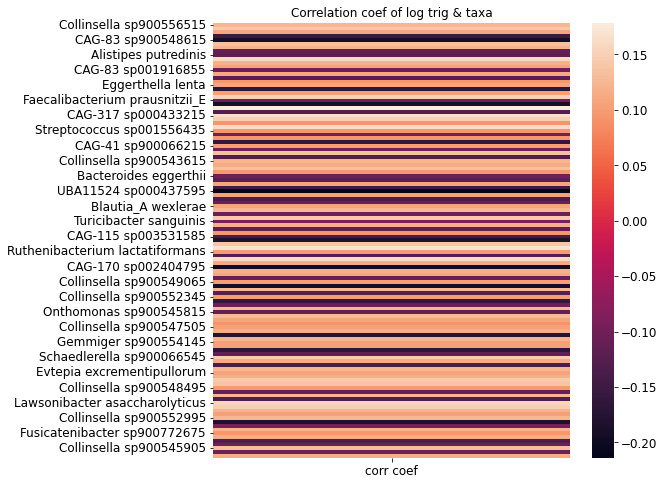

In [63]:
# Visaulize correlation heatmap: 
fig, axes = plt.subplots(figsize=(8,8))
sns.heatmap(log_trig_clr_corr_coef_significant.to_frame('corr coef').astype(float)).set(title='Correlation coef of log trig & taxa')

/groups/umcg-lifelines/tmp01/projects/ov22_0666/personal_directories/noamark/Human2Dogs/noa_h2d/lib/python3.10/site-packages/seaborn/matrix.py:623: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(0, max_dependent_coord * 1.05)


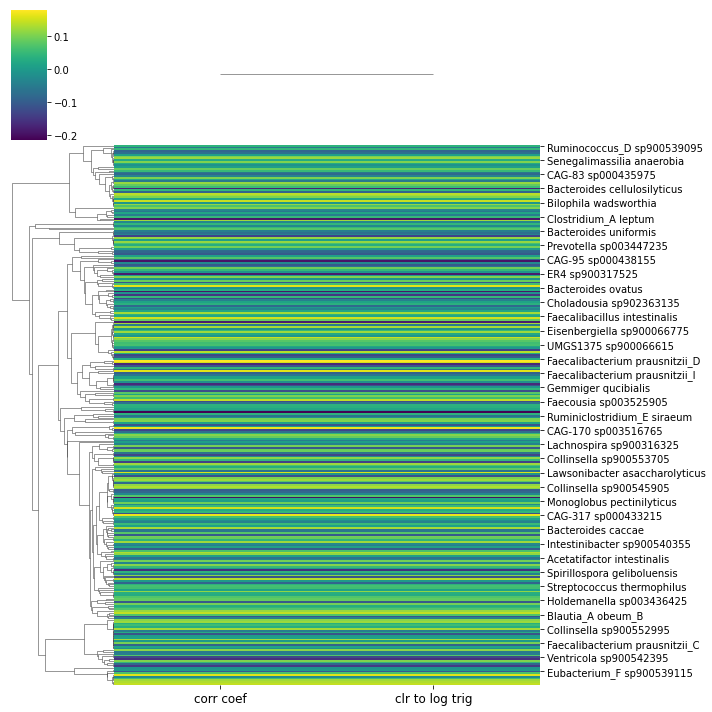

In [44]:
# Visaulize correlation heatmap - using taxonomic hirerical clustering:
# Use the linkage matrix for clustering the rows (taxa)
# TODO: Debug I think I need to pass a linkage file for the y axis - or define not to do any clustering there.

sns.clustermap(df_to_plot, row_linkage=Z, cmap="viridis")

plt.show()


In [15]:
# Select the top 30 (%10) significantly correlated features: 
top_sign_corr_species = log_trig_clr_corr_coef_significant.abs().sort_values(ascending=False).iloc[:30].index

In [25]:
y = trig_at_risk
y_train = y.loc[y_train_samples]
y_test = y.loc[y_test_samples]

train_ft = clr_taxa.loc[X_train_samples, top_sign_corr_species]
test_ft = clr_taxa.loc[X_test_samples, top_sign_corr_species]

params = {'class_weight': 'balanced', 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_split': 50, 'n_estimators': 100}
clf = RandomForestClassifier(random_state=random_state, **params)
clf.fit(train_ft, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=3,
                       min_samples_split=50, random_state=0)

              precision    recall  f1-score   support

       False       0.91      0.81      0.86       146
        True       0.28      0.48      0.35        23

    accuracy                           0.76       169
   macro avg       0.59      0.64      0.60       169
weighted avg       0.82      0.76      0.79       169



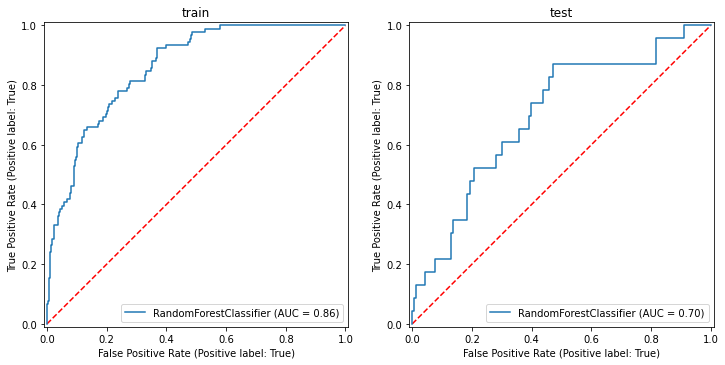

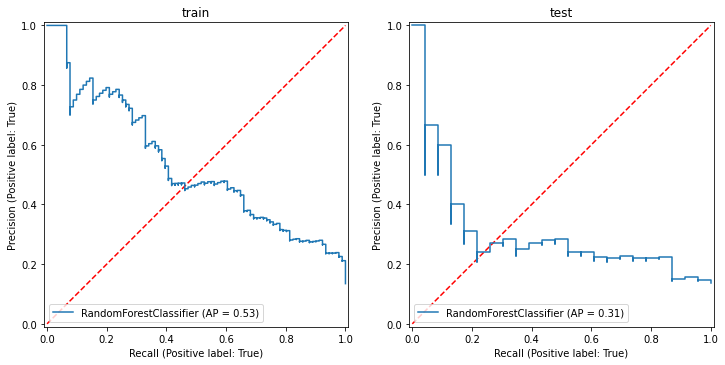

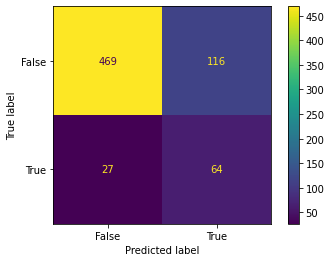

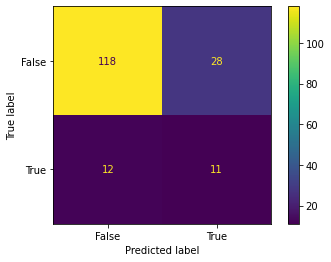

feature importance:


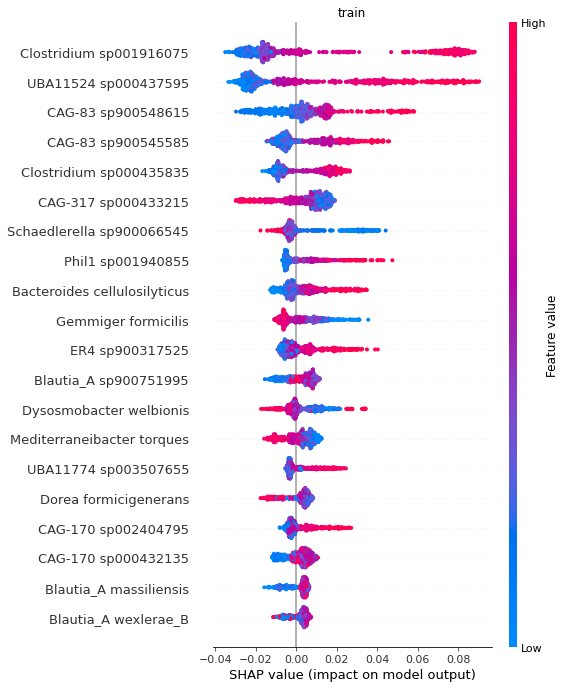

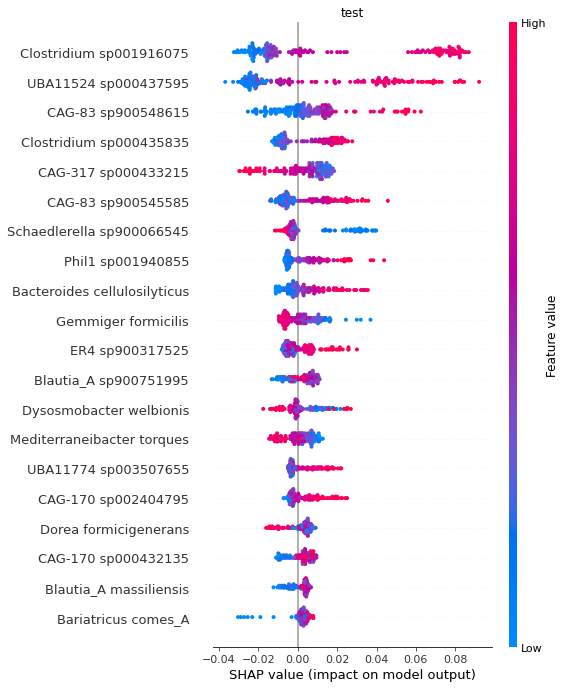

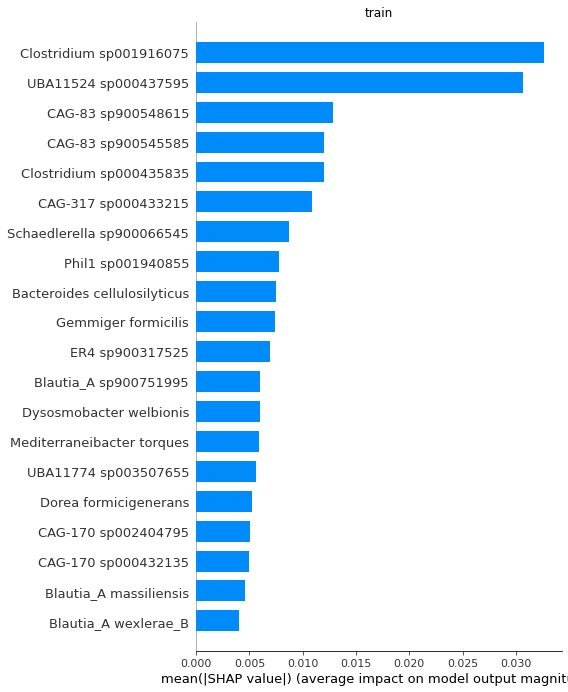

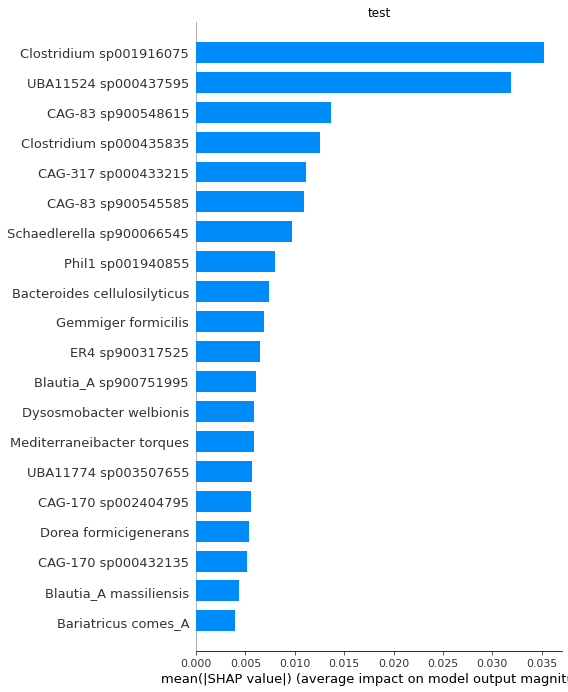

In [26]:
evaluation.report_clf_preformance(clf=clf, X_train=train_ft, y_train=y_train, X_test=test_ft, y_test=y_test)

### V2: